# Getting started with prtecan

In [1]:
import hashlib
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from clophfit import prtecan

%load_ext autoreload
%autoreload 2

os.chdir("../../tests/Tecan/140220/")

## To parse a Tecan file

In [2]:
tf = prtecan.Tecanfile("../290212_6.38.xls")
tf.__dict__

{'path': '../290212_6.38.xls',
 'metadata': {'Device: infinite 200': Metadata(value='Serial number: 810002712', unit=['Serial number of connected stacker:']),
  'Firmware: V_2.11_04/08_InfiniTe (Apr  4 2008/14.37.11)': Metadata(value='MAI, V_2.11_04/08_InfiniTe (Apr  4 2008/14.37.11)', unit=None),
  'Date:': Metadata(value='29/02/2012', unit=None),
  'Time:': Metadata(value='15.57.05', unit=None),
  'System': Metadata(value='TECANROBOT', unit=None),
  'User': Metadata(value='TECANROBOT\\Administrator', unit=None),
  'Plate': Metadata(value='PE 96 Flat Bottom White   [PE.pdfx]', unit=None),
  'Plate-ID (Stacker)': Metadata(value='Plate-ID (Stacker)', unit=None),
  'Shaking (Linear) Duration:': Metadata(value=50, unit=['s']),
  'Shaking (Linear) Amplitude:': Metadata(value=2, unit=['mm'])},
 'labelblocks': [Labelblock(path='../290212_6.38.xls', metadata={'Label': Metadata(value='Label1', unit=None), 'Mode': Metadata(value='Fluorescence Top Reading', unit=None), 'Excitation Wavelength': M

When KEYS are identical labelblocks are considered __eq__ equal i.e. they contain the same measurement.

In [3]:
tf.labelblocks[0].metadata

{'Label': Metadata(value='Label1', unit=None),
 'Mode': Metadata(value='Fluorescence Top Reading', unit=None),
 'Excitation Wavelength': Metadata(value=400, unit=['nm']),
 'Emission Wavelength': Metadata(value=535, unit=['nm']),
 'Excitation Bandwidth': Metadata(value=20, unit=['nm']),
 'Emission Bandwidth': Metadata(value=25, unit=['nm']),
 'Gain': Metadata(value=81, unit=['Manual']),
 'Number of Flashes': Metadata(value=10, unit=None),
 'Integration Time': Metadata(value=20, unit=['µs']),
 'Lag Time': Metadata(value='µs', unit=None),
 'Settle Time': Metadata(value='ms', unit=None),
 'Start Time:': Metadata(value='29/02/2012 15.57.55', unit=None),
 'Temperature': Metadata(value=26.0, unit=['°C']),
 'End Time:': Metadata(value='29/02/2012 15.58.35', unit=None)}

In [4]:
print(tf.labelblocks[0].data)

{'A01': 30072.0, 'A02': 27276.0, 'A03': 22249.0, 'A04': 30916.0, 'A05': 27943.0, 'A06': 25130.0, 'A07': 26765.0, 'A08': 27836.0, 'A09': 23084.0, 'A10': 31370.0, 'A11': 16890.0, 'A12': 22136.0, 'B01': 22336.0, 'B02': 31327.0, 'B03': 24855.0, 'B04': 32426.0, 'B05': 30066.0, 'B06': 27018.0, 'B07': 28269.0, 'B08': 27570.0, 'B09': 31310.0, 'B10': 24358.0, 'B11': 22595.0, 'B12': 20355.0, 'C01': 23232.0, 'C02': 32241.0, 'C03': 28309.0, 'C04': 26642.0, 'C05': 28818.0, 'C06': 26638.0, 'C07': 26423.0, 'C08': 29441.0, 'C09': 28541.0, 'C10': 29656.0, 'C11': 29841.0, 'C12': 25738.0, 'D01': 26578.0, 'D02': 22280.0, 'D03': 36219.0, 'D04': 25735.0, 'D05': 35433.0, 'D06': 27376.0, 'D07': 22497.0, 'D08': 35681.0, 'D09': 26154.0, 'D10': 32311.0, 'D11': 27495.0, 'D12': 22459.0, 'E01': 27576.0, 'E02': 26058.0, 'E03': 28882.0, 'E04': 26188.0, 'E05': 27531.0, 'E06': 31269.0, 'E07': 26757.0, 'E08': 26427.0, 'E09': 27764.0, 'E10': 27184.0, 'E11': 26556.0, 'E12': 18494.0, 'F01': 22120.0, 'F02': 26642.0, 'F03': 

## To group list of files into a titration

In [5]:
tit = prtecan.Titration.fromlistfile("../list.pH")

In [6]:
tit.__dict__

{'tecanfiles': [Tecanfile(path=PosixPath('../290212_5.78.xls'), metadata={'Device: infinite 200': Metadata(value='Serial number: 810002712', unit=['Serial number of connected stacker:']), 'Firmware: V_2.11_04/08_InfiniTe (Apr  4 2008/14.37.11)': Metadata(value='MAI, V_2.11_04/08_InfiniTe (Apr  4 2008/14.37.11)', unit=None), 'Date:': Metadata(value='29/02/2012', unit=None), 'Time:': Metadata(value='16.05.07', unit=None), 'System': Metadata(value='TECANROBOT', unit=None), 'User': Metadata(value='TECANROBOT\\Administrator', unit=None), 'Plate': Metadata(value='PE 96 Flat Bottom White   [PE.pdfx]', unit=None), 'Plate-ID (Stacker)': Metadata(value='Plate-ID (Stacker)', unit=None), 'Shaking (Linear) Duration:': Metadata(value=50, unit=['s']), 'Shaking (Linear) Amplitude:': Metadata(value=2, unit=['mm'])}, labelblocks=[Labelblock(path=PosixPath('../290212_5.78.xls'), metadata={'Label': Metadata(value='Label1', unit=None), 'Mode': Metadata(value='Fluorescence Top Reading', unit=None), 'Excitat

In [7]:
tit.labelblocksgroups[0].labelblocks[0].metadata["Temperature"], tit.labelblocksgroups[
    1
].labelblocks[0].metadata["Temperature"]

(Metadata(value=25.9, unit=['°C']), Metadata(value=26.2, unit=['°C']))

In [8]:
tit.labelblocksgroups[0].metadata

{'Label': Metadata(value='Label1', unit=None),
 'Mode': Metadata(value='Fluorescence Top Reading', unit=None),
 'Excitation Wavelength': Metadata(value=400, unit=['nm']),
 'Emission Wavelength': Metadata(value=535, unit=['nm']),
 'Excitation Bandwidth': Metadata(value=20, unit=['nm']),
 'Emission Bandwidth': Metadata(value=25, unit=['nm']),
 'Number of Flashes': Metadata(value=10, unit=None),
 'Integration Time': Metadata(value=20, unit=['µs']),
 'Lag Time': Metadata(value='µs', unit=None),
 'Settle Time': Metadata(value='ms', unit=None),
 'Gain': Metadata(value=81, unit=None)}

In [9]:
tit.labelblocksgroups[1].metadata

{'Label': Metadata(value='Label2', unit=None),
 'Mode': Metadata(value='Fluorescence Top Reading', unit=None),
 'Excitation Wavelength': Metadata(value=485, unit=['nm']),
 'Emission Wavelength': Metadata(value=535, unit=['nm']),
 'Excitation Bandwidth': Metadata(value=25, unit=['nm']),
 'Emission Bandwidth': Metadata(value=25, unit=['nm']),
 'Number of Flashes': Metadata(value=10, unit=None),
 'Integration Time': Metadata(value=20, unit=['µs']),
 'Lag Time': Metadata(value='µs', unit=None),
 'Settle Time': Metadata(value='ms', unit=None),
 'Movement': Metadata(value='Move Plate Out', unit=None),
 'Gain': Metadata(value=93, unit=None)}

In [10]:
tit.labelblocksgroups[0].data["A01"], tit.labelblocksgroups[0].data["H12"]

([30344.0, 30072.0, 31010.0, 32678.0, 33731.0, 36506.0, 37967.0, 37725.0],
 [21287.0, 20888.0, 21209.0, 21711.0, 22625.0, 23397.0, 24791.0, 25045.0])

## pH titration analysis

In [11]:
ph = prtecan.Titration.fromlistfile("list.pH")

/home/dan/workspace/ClopHfit/src/clophfit/prtecan/prtecan.py:353: UserWarning: OVER
 Overvalue in Label1:H02 of tecanfile pH7.6_200214.xls
  self.data: dict[str, float] = self._extract_data(lines[15:23])
/home/dan/workspace/ClopHfit/src/clophfit/prtecan/prtecan.py:353: UserWarning: OVER
 Overvalue in Label1:H02 of tecanfile pH7.1_200214.xls
  self.data: dict[str, float] = self._extract_data(lines[15:23])
/home/dan/workspace/ClopHfit/src/clophfit/prtecan/prtecan.py:353: UserWarning: OVER
 Overvalue in Label1:A06 of tecanfile pH6.5_200214.xls
  self.data: dict[str, float] = self._extract_data(lines[15:23])
/home/dan/workspace/ClopHfit/src/clophfit/prtecan/prtecan.py:353: UserWarning: OVER
 Overvalue in Label1:H02 of tecanfile pH6.5_200214.xls
  self.data: dict[str, float] = self._extract_data(lines[15:23])
/home/dan/workspace/ClopHfit/src/clophfit/prtecan/prtecan.py:353: UserWarning: OVER
 Overvalue in Label1:A06 of tecanfile pH5.8_200214.xls
  self.data: dict[str, float] = self._extract

In [12]:
ph_an = prtecan.TitrationAnalysis.fromlistfile("./list.pH")
ph_an.load_scheme("./scheme.txt")
print(ph_an.scheme)
ph_an.labelblocksgroups[1].data["D01"]

PlateScheme(file='./scheme.txt', _buffer=['D01', 'E01', 'D12', 'E12'], _ctrl=['A01', 'H12', 'C12', 'F12', 'H01', 'C01', 'F01', 'G12', 'B01', 'A12', 'G01', 'B12'], _names={'G03': {'A01', 'H12', 'B12'}, 'NTT': {'F01', 'C12', 'F12'}, 'S202N': {'C01', 'G12', 'H01'}, 'V224Q': {'B01', 'G01', 'A12'}})


/home/dan/workspace/ClopHfit/src/clophfit/prtecan/prtecan.py:353: UserWarning: OVER
 Overvalue in Label1:H02 of tecanfile pH7.6_200214.xls
  self.data: dict[str, float] = self._extract_data(lines[15:23])
/home/dan/workspace/ClopHfit/src/clophfit/prtecan/prtecan.py:353: UserWarning: OVER
 Overvalue in Label1:H02 of tecanfile pH7.1_200214.xls
  self.data: dict[str, float] = self._extract_data(lines[15:23])
/home/dan/workspace/ClopHfit/src/clophfit/prtecan/prtecan.py:353: UserWarning: OVER
 Overvalue in Label1:A06 of tecanfile pH6.5_200214.xls
  self.data: dict[str, float] = self._extract_data(lines[15:23])
/home/dan/workspace/ClopHfit/src/clophfit/prtecan/prtecan.py:353: UserWarning: OVER
 Overvalue in Label1:H02 of tecanfile pH6.5_200214.xls
  self.data: dict[str, float] = self._extract_data(lines[15:23])
/home/dan/workspace/ClopHfit/src/clophfit/prtecan/prtecan.py:353: UserWarning: OVER
 Overvalue in Label1:A06 of tecanfile pH5.8_200214.xls
  self.data: dict[str, float] = self._extract

[51.0, 52.0, 50.0, 51.0, 55.0, 58.0, 57.0]

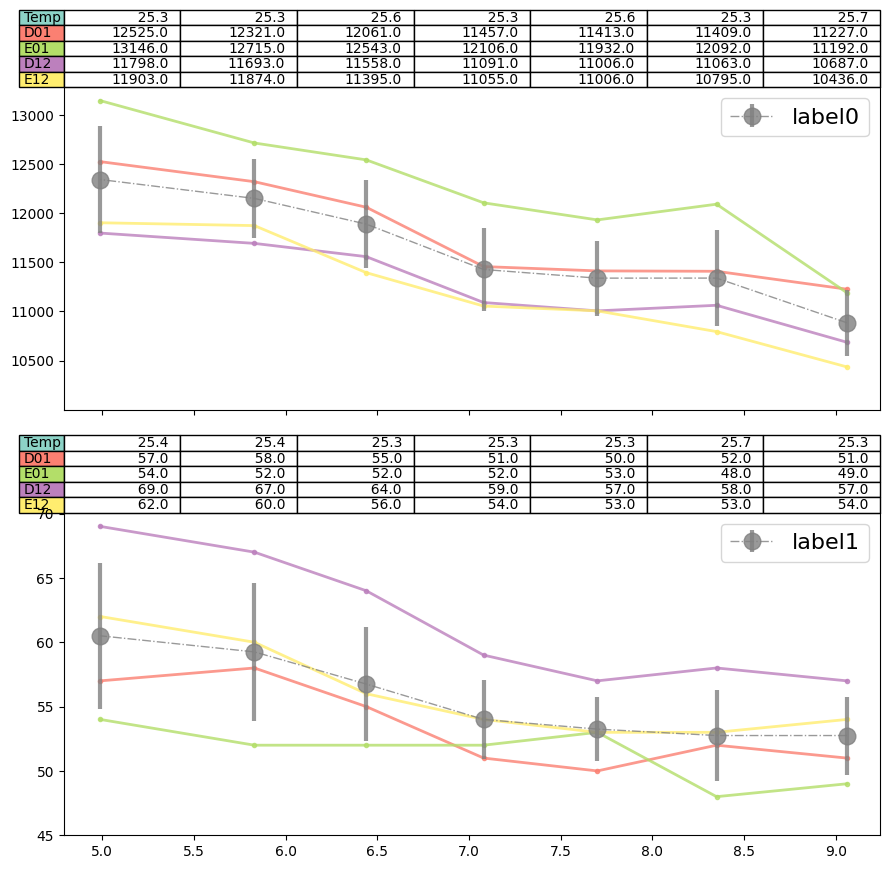

In [13]:
g = ph_an.plot_buffer()

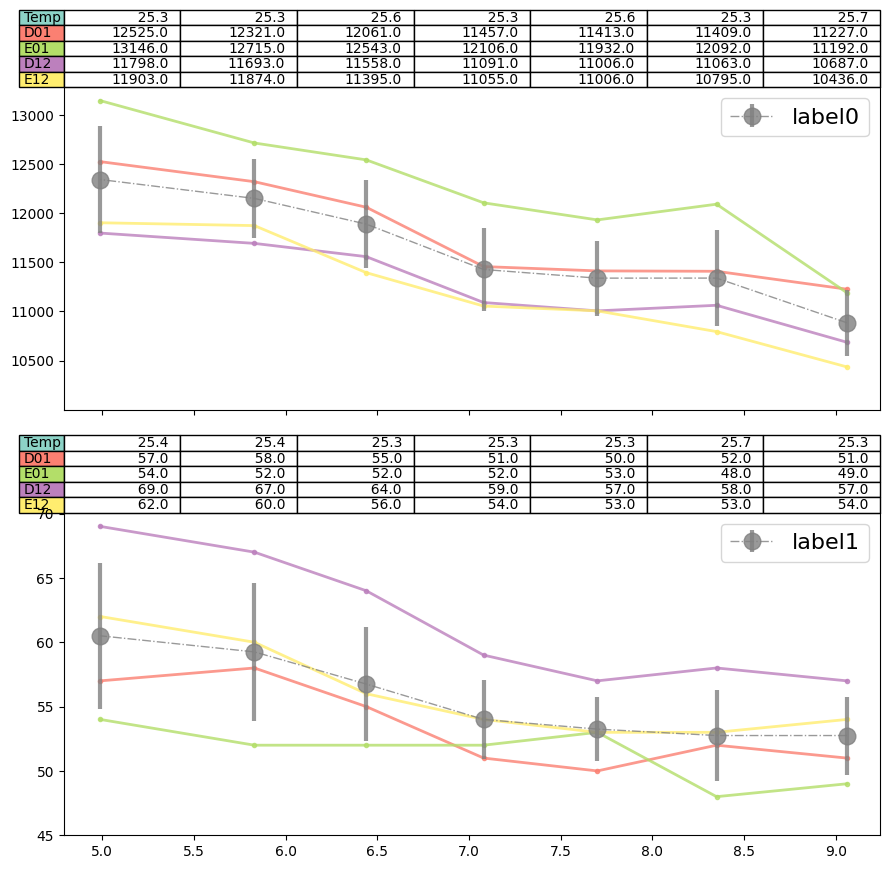

In [14]:
ph_an.load_additions("additions.pH")
g = ph_an.plot_buffer()

In [16]:
ph_an.fit("pH")

ph_an.fittings[0].loc["A11"]

ss                                                        1
msg       Both actual and predicted relative reductions ...
df                                                      4.0
tval                                               2.776445
chisqr                                       3189823.301693
K                                                   7.84803
SA                                              31197.13572
SB                                             22403.941526
sK                                                 1.204218
sSA                                             2914.849286
sSB                                             5639.545141
ctrl                                                    NaN
Name: A11, dtype: object

In [198]:
import lmfit
import emcee
import arviz as az

from clophfit.binding import fitting

ph_an.scheme

PlateScheme(file='./scheme.txt', _buffer=['D01', 'E01', 'D12', 'E12'], _ctrl=['A01', 'H12', 'C12', 'F12', 'H01', 'C01', 'F01', 'G12', 'B01', 'A12', 'G01', 'B12'], _names={'G03': {'A01', 'H12', 'B12'}, 'NTT': {'F01', 'C12', 'F12'}, 'S202N': {'C01', 'G12', 'H01'}, 'V224Q': {'B01', 'G01', 'A12'}})

name,value,standard error,relative error,initial value,min,max,vary
K,7.04634886,0.05369597,(0.76%),7,0.00000000,inf,True
S0_1,343.605028,6.35196325,(1.85%),338.59375,-inf,inf,True
S1_1,33.2637101,6.48678757,(19.50%),25.650000000000002,-inf,inf,True


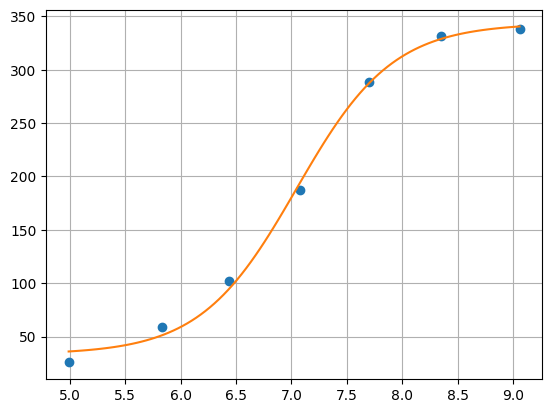

In [232]:
well = "A02"
y0 = np.array(ph_an.data_dilutioncorrected_norm[0][well])
y1 = np.array(ph_an.data_dilutioncorrected_norm[1][well])
x = np.array(ph_an.conc)
xc = {1: x}
yc = {1: y1}
res, mini = fitting.analyze_binding_glob("pH", xc, yc)[1:]
res.params

In [236]:
result_emcee = mini.emcee(
    burn=300, steps=750, params=res.params, is_weighted=True, thin=20, progress=True
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 750/750 [00:10<00:00, 68.49it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 15;
tau: [32.49635658 30.14462587 29.702467   33.47158945 33.9269083 ]


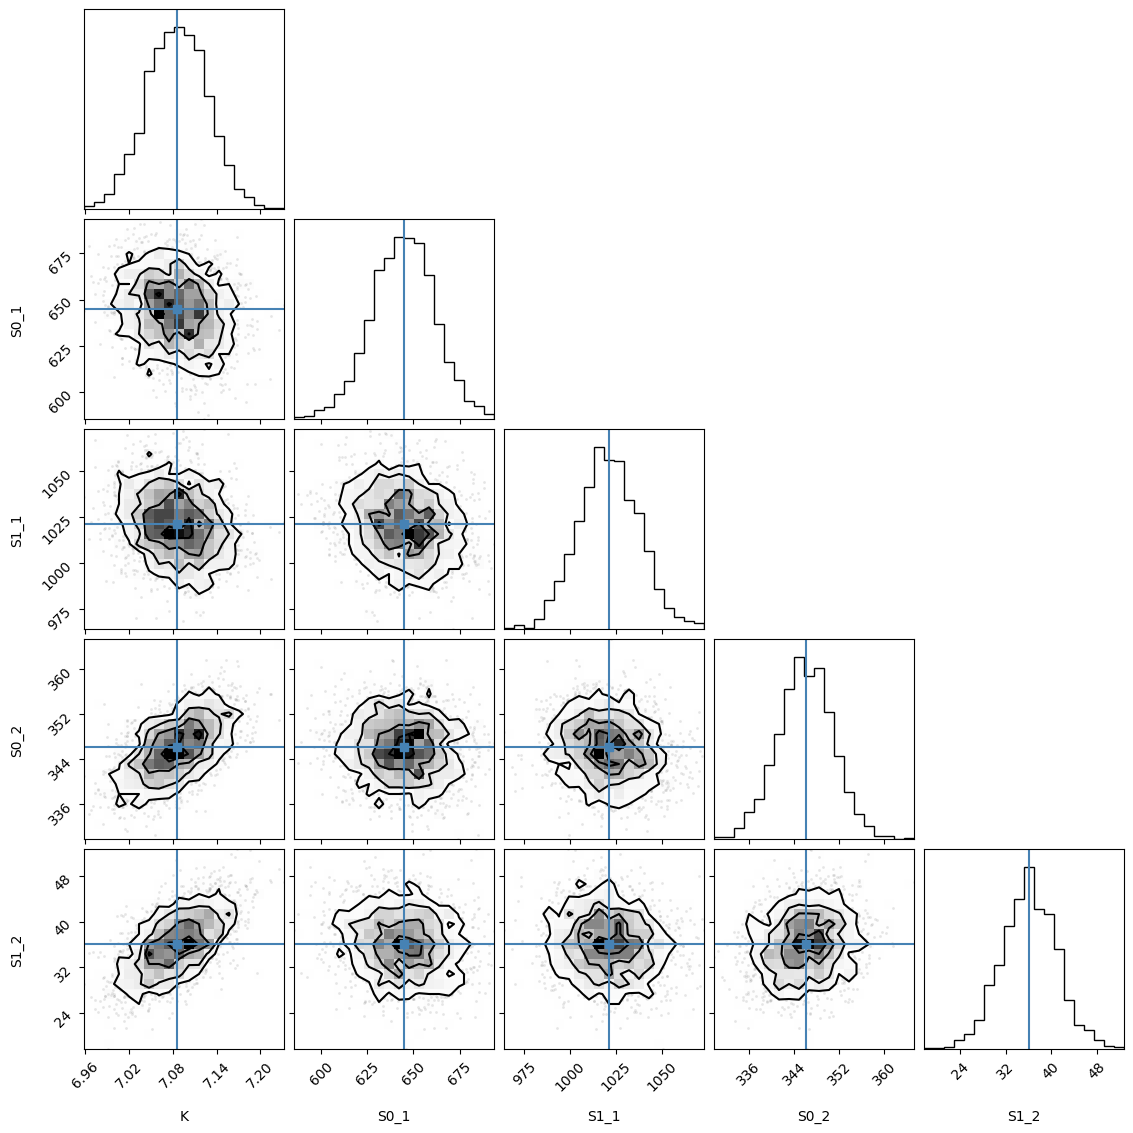

In [237]:
emcee_plot = corner.corner(
    result_emcee.flatchain,
    labels=result_emcee.var_names,
    truths=list(result_emcee.params.valuesdict().values()),
)

In [246]:
res.params

name,value,standard error,relative error,initial value,min,max,vary
K,7.08547526,0.06619571,(0.93%),7,0.00000000,inf,True
S0_1,644.201144,29.0086597,(4.50%),610.3494623655913,-inf,inf,True
S1_1,1020.55971,28.8345249,(2.83%),951.1569892473119,-inf,inf,True
S0_2,346.263699,8.17043473,(2.36%),338.59375,-inf,inf,True
S1_2,35.9941935,8.09078585,(22.48%),25.650000000000002,-inf,inf,True


In [247]:
R1 = res.params["S0_1"].value / res.params["S1_1"].value
R2 = res.params["S0_2"].value / res.params["S1_2"].value
res.params.add("R_1", value=R1, min=0, max=200)
res.params.add("R_2", value=R2, min=0, max=200)
res.params.pop("S0_1")
res.params.pop("S0_2")
# res.params.add("__lnsigma", value=np.log(0.1), min=np.log(0.001), max=np.log(6))
res.params

name,value,standard error,relative error,initial value,min,max,vary
K,7.08547526,0.06619571,(0.93%),7,0.00000000,inf,True
S1_1,1020.55971,28.8345249,(2.83%),951.1569892473119,-inf,inf,True
S1_2,35.9941935,8.09078585,(22.48%),25.650000000000002,-inf,inf,True
R_1,0.63122337,,,0.6312233730338088,0.00000000,200.000000,True
R_2,9.61998771,,,9.619987706549757,0.00000000,200.000000,True


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [01:43<00:00,  7.73it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 16;
tau: [43.94100557 36.21751987 66.21017574 35.03685216 66.75442167 18.76368027]


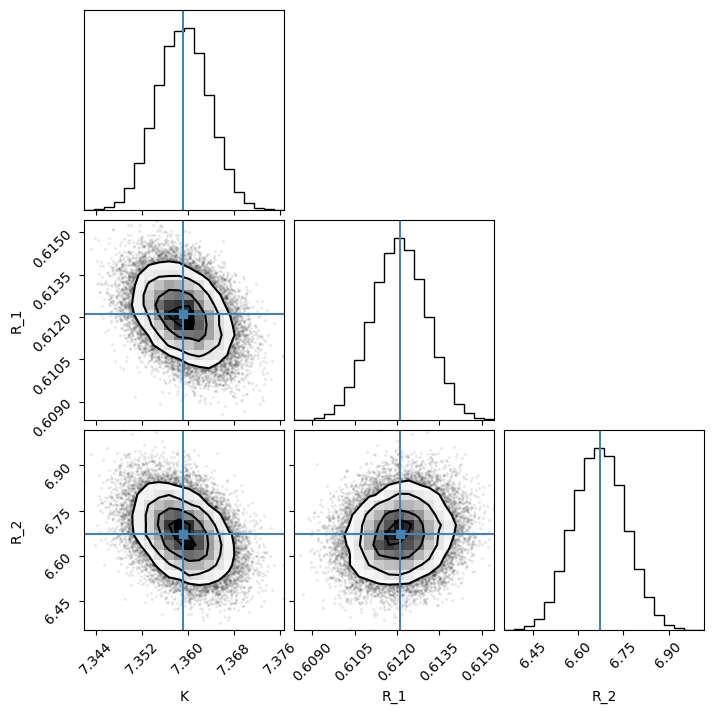

In [253]:
res = lmfit.minimize(
    fitting._binding_residuals_r,
    args=(fitting._binding_pkr, xc, yc),  # NB: no weights
    method="emcee",
    nan_policy="omit",
    burn=300,
    steps=800,
    thin=20,
    nwalkers=100,
    params=res.params,
    is_weighted=True,
    progress=True,
)

emcee_plot = corner.corner(
    res.flatchain[["K", "R_1", "R_2"]],
    labels=["K", "R_1", "R_2"],
    truths=[res.params["K"].value, res.params["R_1"].value, res.params["R_2"].value],
)

Value at which the probability of being higher is 99%: 6.991811090884496
Proportion of K samples above 7.88: 0.0


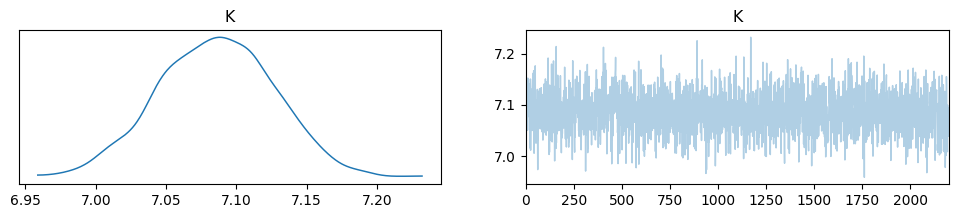

In [244]:
# Run MCMC sampling using emcee
# result_emcee = res.emcee(burn=300, steps=1500, thin=1, params=res.params)

# Get a dictionary of flatchains (i.e., the traces of the parameters)
# samples = result_emcee.flatchain
samples = result_emcee.flatchain[["K"]]

# Convert the dictionary of flatchains to an ArviZ InferenceData object
samples_dict = {key: np.array(val) for key, val in samples.items()}
idata = az.from_dict(posterior=samples_dict)

# Plot the results
az.plot_trace(idata)

k_samples = idata.posterior["K"].values
percentile_value = np.percentile(k_samples, 1)
print(f"Value at which the probability of being higher is 99%: {percentile_value}")

# Calculate the proportion of samples where K > threshold
threshold = 7.88
proportion_above_threshold = (k_samples > threshold).mean()
print(f"Proportion of K samples above {threshold}: {proportion_above_threshold}")

name,value,standard error,relative error,initial value,min,max,vary
K,7.35905476,0.12742705,(1.73%),7,0.00000000,inf,True
S0_1,614.149577,25.2869227,(4.12%),610.3494623655913,-inf,inf,True
S1_1,1003.34017,20.5468399,(2.05%),951.1569892473119,-inf,inf,True
S0_2,365.166040,23.9831053,(6.57%),338.59375,-inf,inf,True
S1_2,54.7499875,19.7891071,(36.14%),25.650000000000002,-inf,inf,True


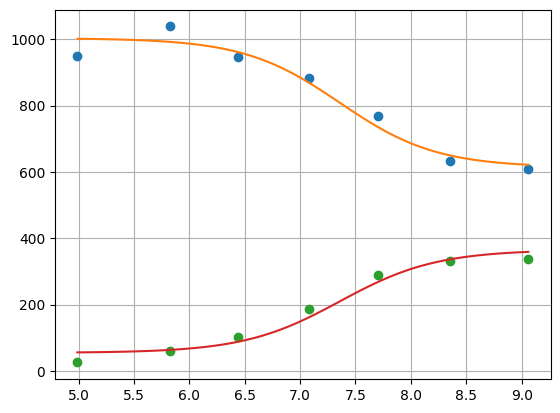

In [259]:
xc = {1: x[:], 2: x[:]}
yc = {1: y0[:], 2: y1[:]}
res, mini = fitting.analyze_binding_glob("pH", xc, yc)[1:]
res.params

In [215]:
std = np.std(res.residual)
res.residual, std

(array([-0.86741455,  0.57867534,  1.23968951,  0.51424713,  0.37449253,
         0.7385859 , -2.57827586, -0.84251356,  1.80624375, -1.61213355,
         0.63931296,  0.29172775, -0.05023987, -0.23239749]),
 1.113023311913746)

In [183]:
threshold = 1.5 * 1437
outliers = np.abs(res.residual) > threshold
outliers

array([False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False])

## Cl titration analysis

In [16]:
cl_an = prtecan.TitrationAnalysis.fromlistfile("list.cl")
cl_an.load_scheme("scheme.txt")
cl_an.scheme

/home/dan/workspace/ClopHfit/src/clophfit/prtecan/prtecan.py:312: UserWarning: OVER
 Overvalue in Label1:H02 of tecanfile pH5.0_200214.xls
  self.data: dict[str, float] = self._extract_data(lines[15:23])


PlateScheme(file='scheme.txt', buffer=['D01', 'E01', 'D12', 'E12'], ctrl=['B01', 'C12', 'H01', 'A01', 'G12', 'F12', 'G01', 'B12', 'F01', 'A12', 'C01', 'H12'], names={'G03': {'H12', 'B12', 'A01'}, 'NTT': {'F01', 'F12', 'C12'}, 'S202N': {'C01', 'H01', 'G12'}, 'V224Q': {'A12', 'G01', 'B01'}})

In [17]:
cl_an.load_additions("additions.cl")
print(cl_an.conc)
cl_an.conc = prtecan.calculate_conc(cl_an.additions, 1000)
cl_an.conc

[0, 0, 0, 0, 0, 0, 0, 0, 0]


array([  0.        ,  17.54385965,  34.48275862,  50.84745763,
        66.66666667,  81.96721311,  96.77419355, 138.46153846,
       164.17910448])

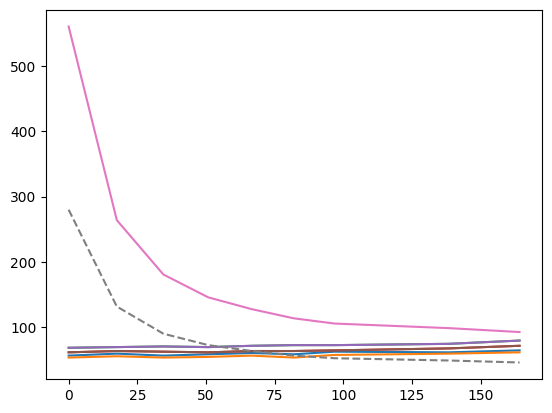

In [18]:
lbg = cl_an.labelblocksgroups[1]
x = cl_an.conc
plt.plot(x, lbg.data["D01"])
plt.plot(x, lbg.data["E01"])
plt.plot(x, lbg.data["D12"])
plt.plot(x, lbg.data["E12"])
plt.plot(x, cl_an.labelblocksgroups[1].data["D12"])
plt.plot(x, cl_an.labelblocksgroups[1].data["E12"])
plt.plot(x, lbg.data["A11"])
plt.plot(x, np.array(cl_an.labelblocksgroups[1].data["A11"]) / 2, "--")

In [19]:
lbg.labelblocks[1].buffer

62.5

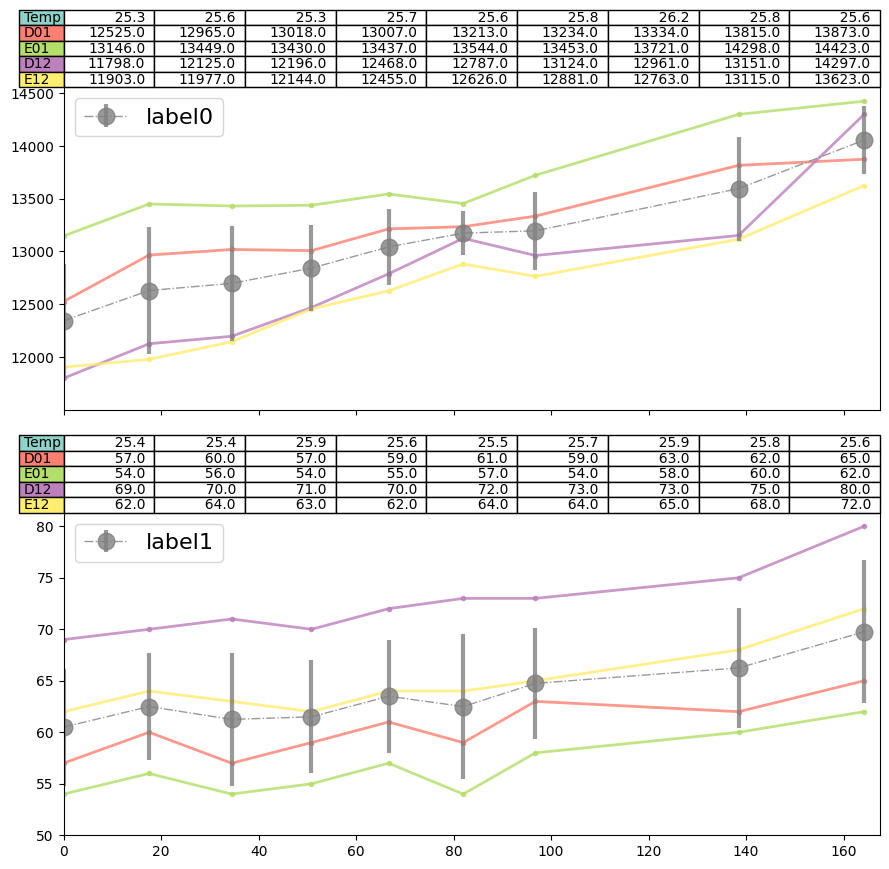

In [20]:
f = cl_an.plot_buffer()

## Fitting

TitrationAnalysis class need API changes to better rationalize its use.

In [21]:
ph_an.fit("pH", fin=-1, tval=0.95)
type(ph_an.fittings)

list

In [22]:
# ph_an.fittings[1].to_csv('fit1-1.csv')
ph_an.fittings[1]

,ss,msg,df,tval,chisqr,K,SA,SB,sK,sSA,sSB,ctrl
F10,1,Both actual and predicted relative reductions ...,3,3.182446,6693.437017,7.392060,173.191371,2397.601964,0.253098,230.970124,227.175160,NaN
F05,1,Both actual and predicted relative reductions ...,3,3.182446,71.339265,7.967075,286.493656,4436.350293,0.015118,18.673010,33.912982,NaN
C02,1,Both actual and predicted relative reductions ...,3,3.182446,1189.845980,7.111161,372.490817,2498.509163,0.114808,115.910030,84.615790,NaN
G03,1,Both actual and predicted relative reductions ...,3,3.182446,18685.315353,8.000562,264.242815,7200.728074,0.147956,298.850672,564.906314,NaN
G11,1,Both actual and predicted relative reductions ...,3,3.182446,100.323661,8.057604,120.616011,1566.668760,0.053034,21.496166,43.572261,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
C03,1,Both actual and predicted relative reductions ...,3,3.182446,4585.873884,6.904054,1125.893478,6158.368236,0.100773,269.585029,154.139517,NaN
E02,1,Both actual and predicted relative reductions ...,3,3.182446,4809.652367,8.012438,430.617399,7776.125864,0.071165,151.030696,289.614135,NaN
F01,1,Both actual and predicted relative reductions ...,3,3.182446,6563.935327,7.540270,1095.373842,7939.778918,0.081497,212.126197,242.899640,NTT
A12,1,Both actual and predicted relative reductions ...,3,3.182446,79295.720807,8.108638,372.770924,10999.586294,0.206807,594.724249,1285.714864,V224Q


In [23]:
ph_an.fittings[1].loc[["H06", "A01"]]

,ss,msg,df,tval,chisqr,K,SA,SB,sK,sSA,sSB,ctrl
H06,1,Both actual and predicted relative reductions ...,3,3.182446,85.730623,8.044499,583.667709,9807.482415,0.007650,19.955025,39.796818,NaN
A01,1,Both actual and predicted relative reductions ...,3,3.182446,1912.411207,7.939952,308.491030,5053.296317,0.067897,97.573993,171.649842,G03


In [24]:
key = "H06"
lbg = ph_an.labelblocksgroups[1]
x = ph_an.conc
y = lbg.data[key]
dd = prtecan.prtecan.fit_titration("pH", x[:-1], y[:-1])
dd

,ss,msg,df,tval,chisqr,K,SA,SB,sK,sSA,sSB
0,1,Both actual and predicted relative reductions ...,3,3.182446,85.730623,8.044499,583.667709,9807.482415,0.00765,19.955025,39.796818


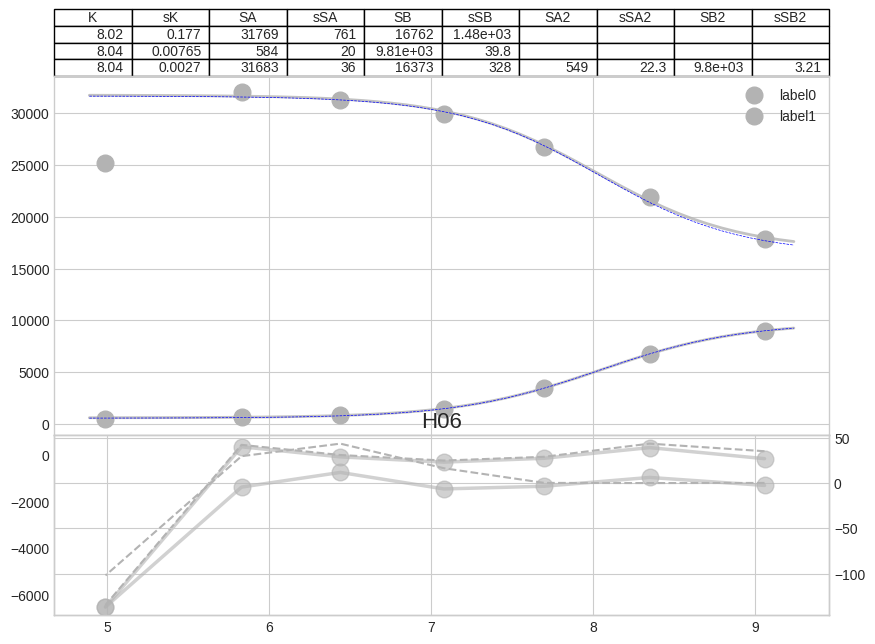

In [25]:
ph_an.plot_well("H06")

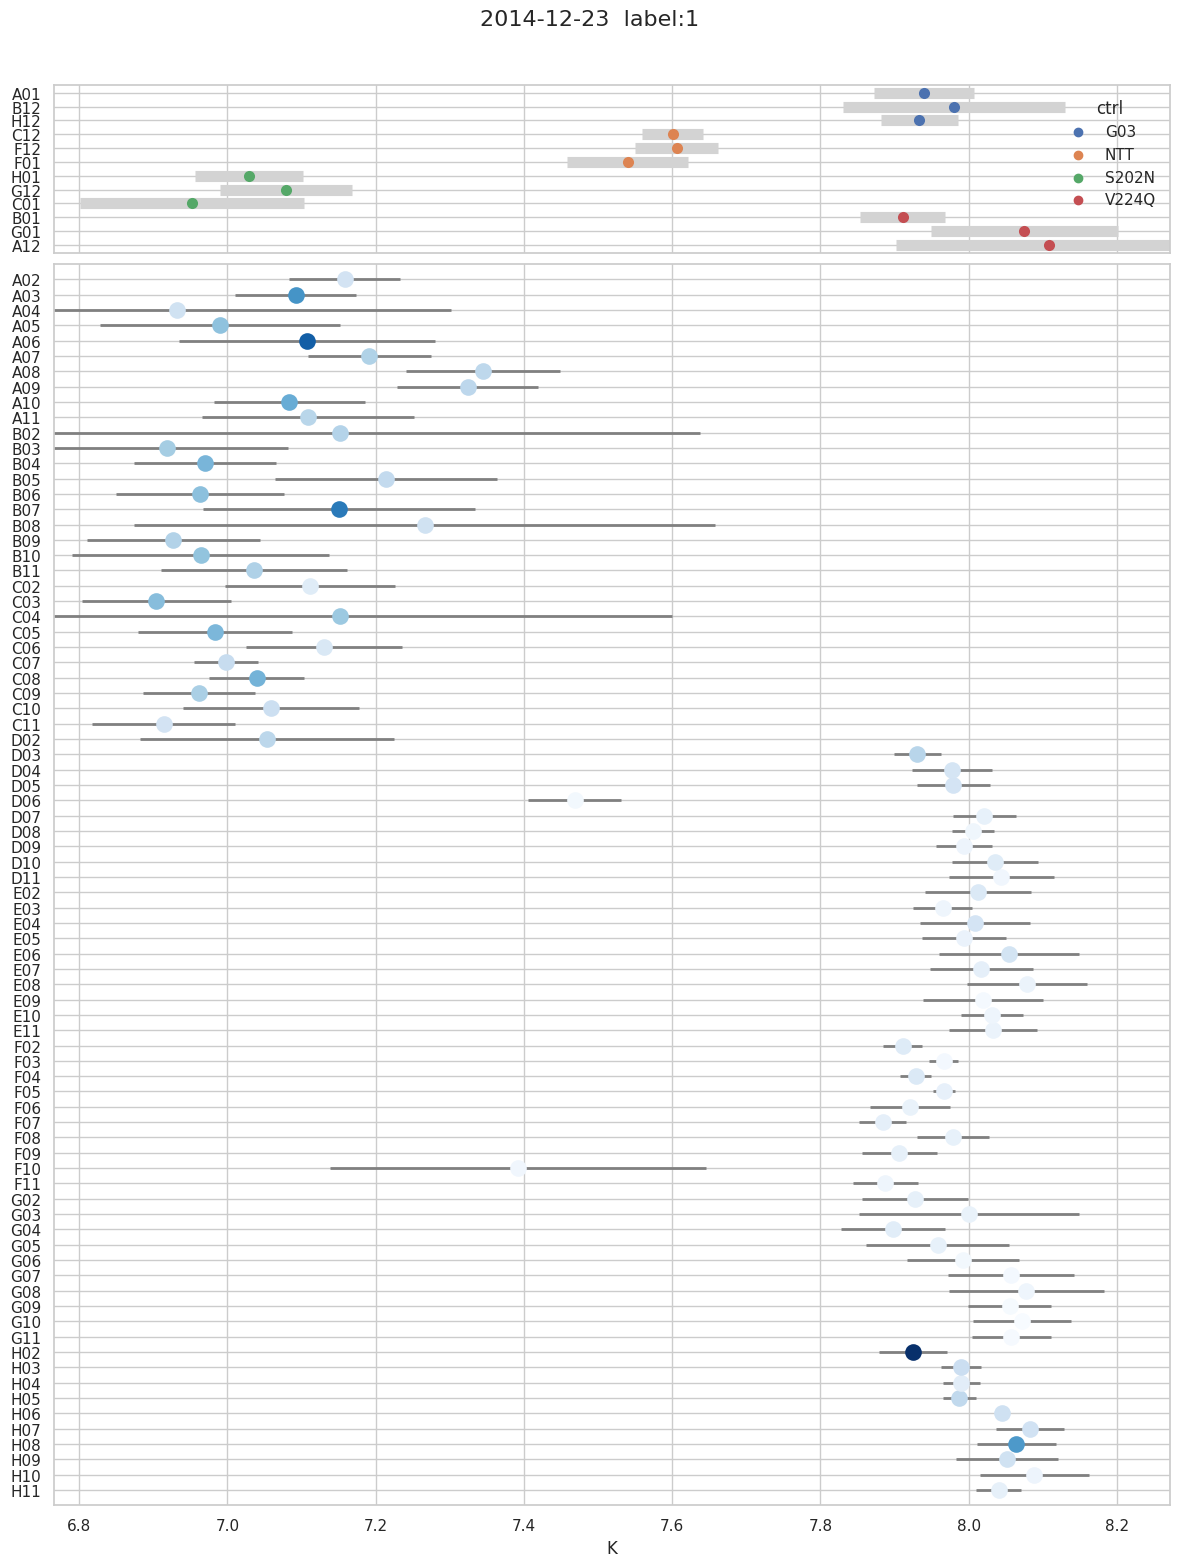

In [26]:
f = ph_an.plot_k(1, title="2014-12-23")

In [27]:
cl_an.fit("Cl", fin=None)

In [ ]:
cl_an.plot_all_wells("cl.pdf")

In [28]:
ph_an.print_fitting(2)

          K      sK      SA     sSA      SB     sSB     SA2    sSA2     SB2    sSB2
  G03
A01    8.12    0.07   22500     318   13976     400     624     277    5215     257 
B12    8.15    0.03   18666      77   14000      33     522    1640    2845     331 
H12    7.71    0.02   23432     236   14741      11     353      81    5584     146 
  NTT
C12    7.80    0.11   22069     648   14721     575     957     294    2554      26 
F12    7.72    0.09   23474     567   15716     613     586     253    2842      55 
F01    7.64    0.04   47972      33   23856     375    1573    1038    7997      54 
  S202N
H01    7.15    0.00   36727       0   24994       8    1197    1081    5148      14 
G12    7.34    0.15   22702     346   16628     178     817     189    2384     141 
C01    7.39    0.30   43803     220   30991    1494    3709    2136    7038     390 
  V224Q
B01    8.00    0.03   40086     263   23554     346    1523     900   15426      91 
G01    8.19    0.03   42427     521   

### selection

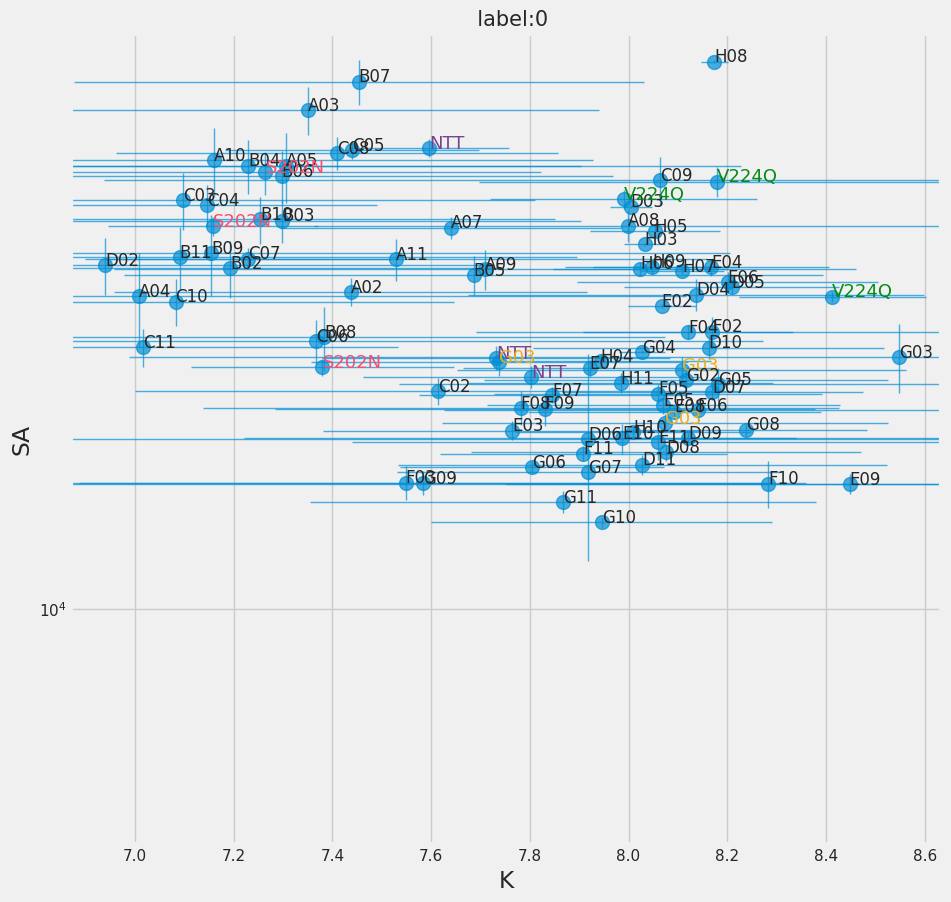

In [29]:
f = ph_an.plot_ebar(0)

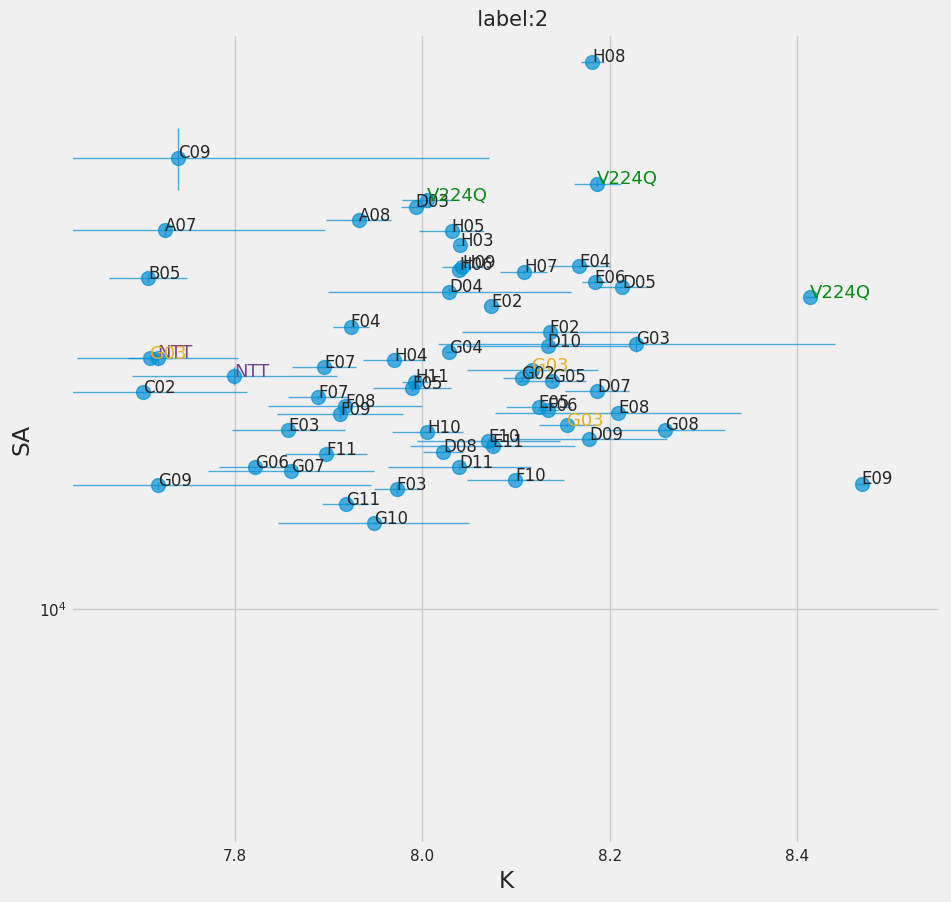

In [30]:
f = ph_an.plot_ebar(2, xmin=7.7, ymin=25)

/home/dan/workspace/ClopHfit/.hatch/clophfit/lib/python3.10/site-packages/seaborn/axisgrid.py:1609: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=x, y=y, **kwargs)
/home/dan/workspace/ClopHfit/.hatch/clophfit/lib/python3.10/site-packages/seaborn/axisgrid.py:1609: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=x, y=y, **kwargs)
/home/dan/workspace/ClopHfit/.hatch/clophfit/lib/python3.10/site-packages/seaborn/axisgrid.py:1609: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=x, y=y, **kwargs)
/home/dan/workspace/ClopHfit/.hatch/clophfit/lib/python3.10/site-packages/seaborn/axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/home/dan/workspace/ClopHfit/.hatch/clophfit/lib/python3.10/site-packages/seaborn/axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  

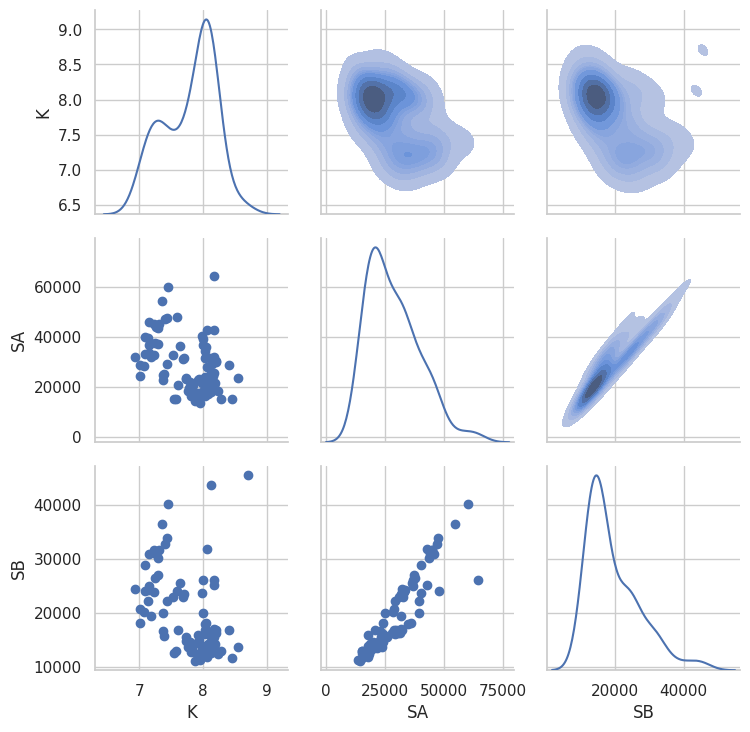

In [31]:
import seaborn as sb

sb.set_style("whitegrid")
g = sb.PairGrid(
    ph_an.fittings[0],
    x_vars=["K", "SA", "SB"],
    y_vars=["K", "SA", "SB"],
    # hue='SB',
    palette="Blues",
    diag_sharey=False,
)

g.map_lower(plt.scatter)
g.map_upper(sb.kdeplot, fill=True)
g.map_diag(sb.kdeplot)

Fit first (0) and second (1) dataset and global (2).

/home/dan/workspace/ClopHfit/.hatch/clophfit/lib/python3.10/site-packages/seaborn/axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/home/dan/workspace/ClopHfit/.hatch/clophfit/lib/python3.10/site-packages/seaborn/axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/home/dan/workspace/ClopHfit/.hatch/clophfit/lib/python3.10/site-packages/seaborn/axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/home/dan/workspace/ClopHfit/.hatch/clophfit/lib/python3.10/site-packages/seaborn/axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/home/dan/workspace/ClopHfit/.hatch/clophfit/lib/python3.10/site-packages/seaborn/axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has be

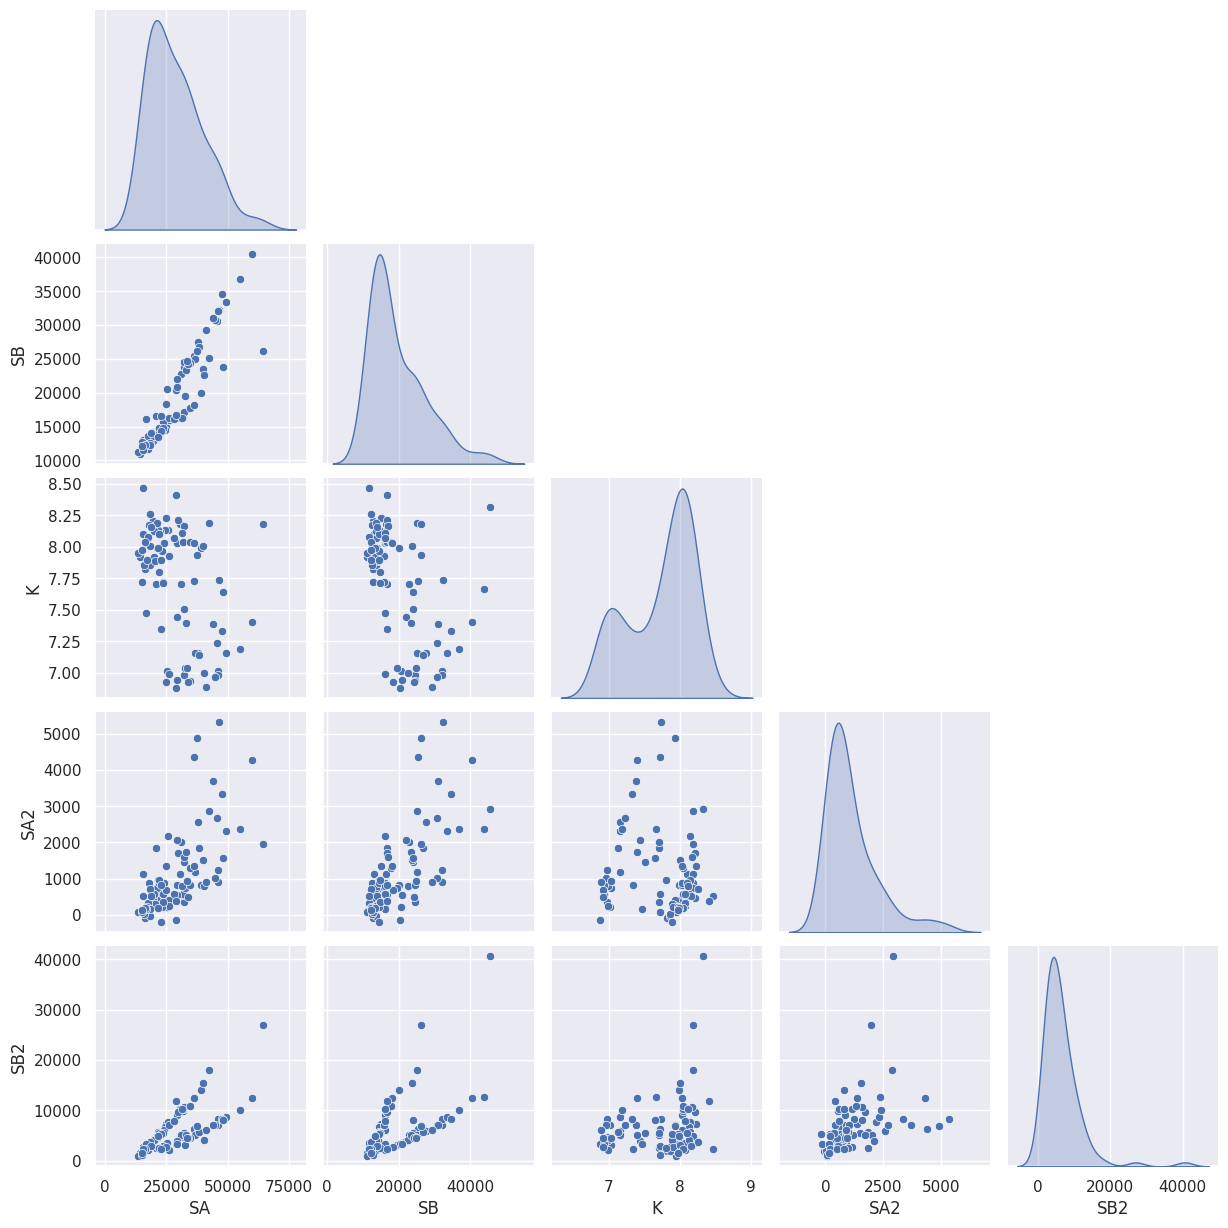

In [32]:
with sb.axes_style("darkgrid"):
    g = sb.pairplot(
        ph_an.fittings[2][["SA", "SB", "K", "SA2", "SB2"]],
        # hue='SB',
        palette="Reds",
        corner=True,
        diag_kind="kde",
    )

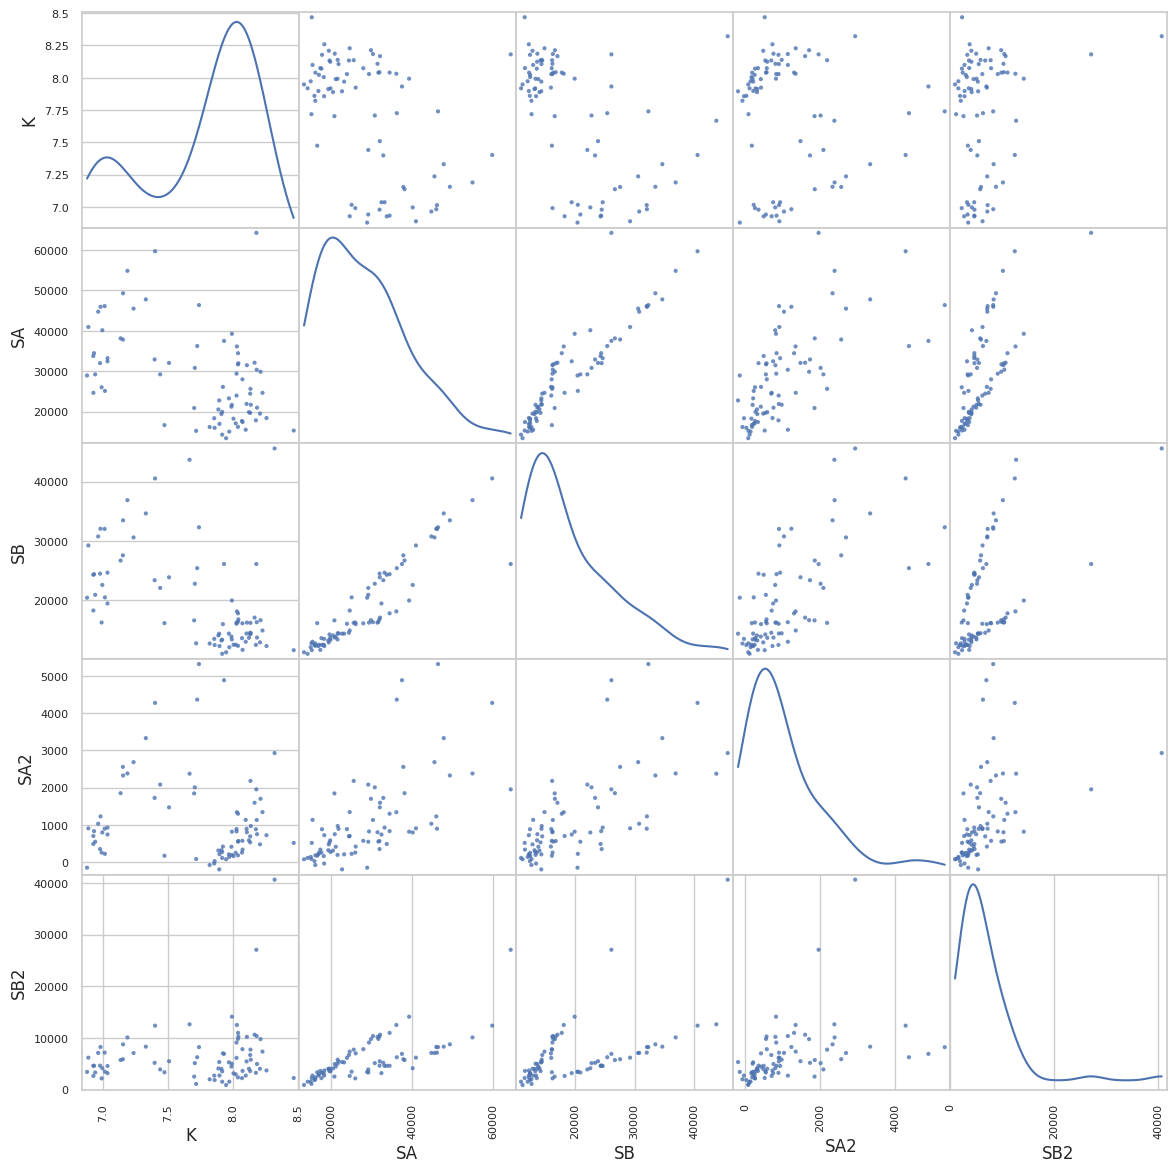

In [33]:
from pandas.plotting import scatter_matrix


def plot_matrix(tit, lb):
    df = tit.fittings[lb].loc[tit.keys_unk]
    try:
        f = scatter_matrix(
            df[["K", "SA", "SB", "SA2", "SB2"]],
            figsize=(14, 14),
            diagonal="kde",
            alpha=0.8,
        )
    except KeyError:
        f = scatter_matrix(
            df[["K", "SA", "SB"]], figsize=(10, 10), diagonal="kde", alpha=0.8
        )
    return f


f = plot_matrix(ph_an, 2)

### combining

In [34]:
res_unk = ph_an.fittings[1].loc[ph_an.keys_unk].sort_index()
res_unk["well"] = res_unk.index

<Figure size 2400x1400 with 0 Axes>

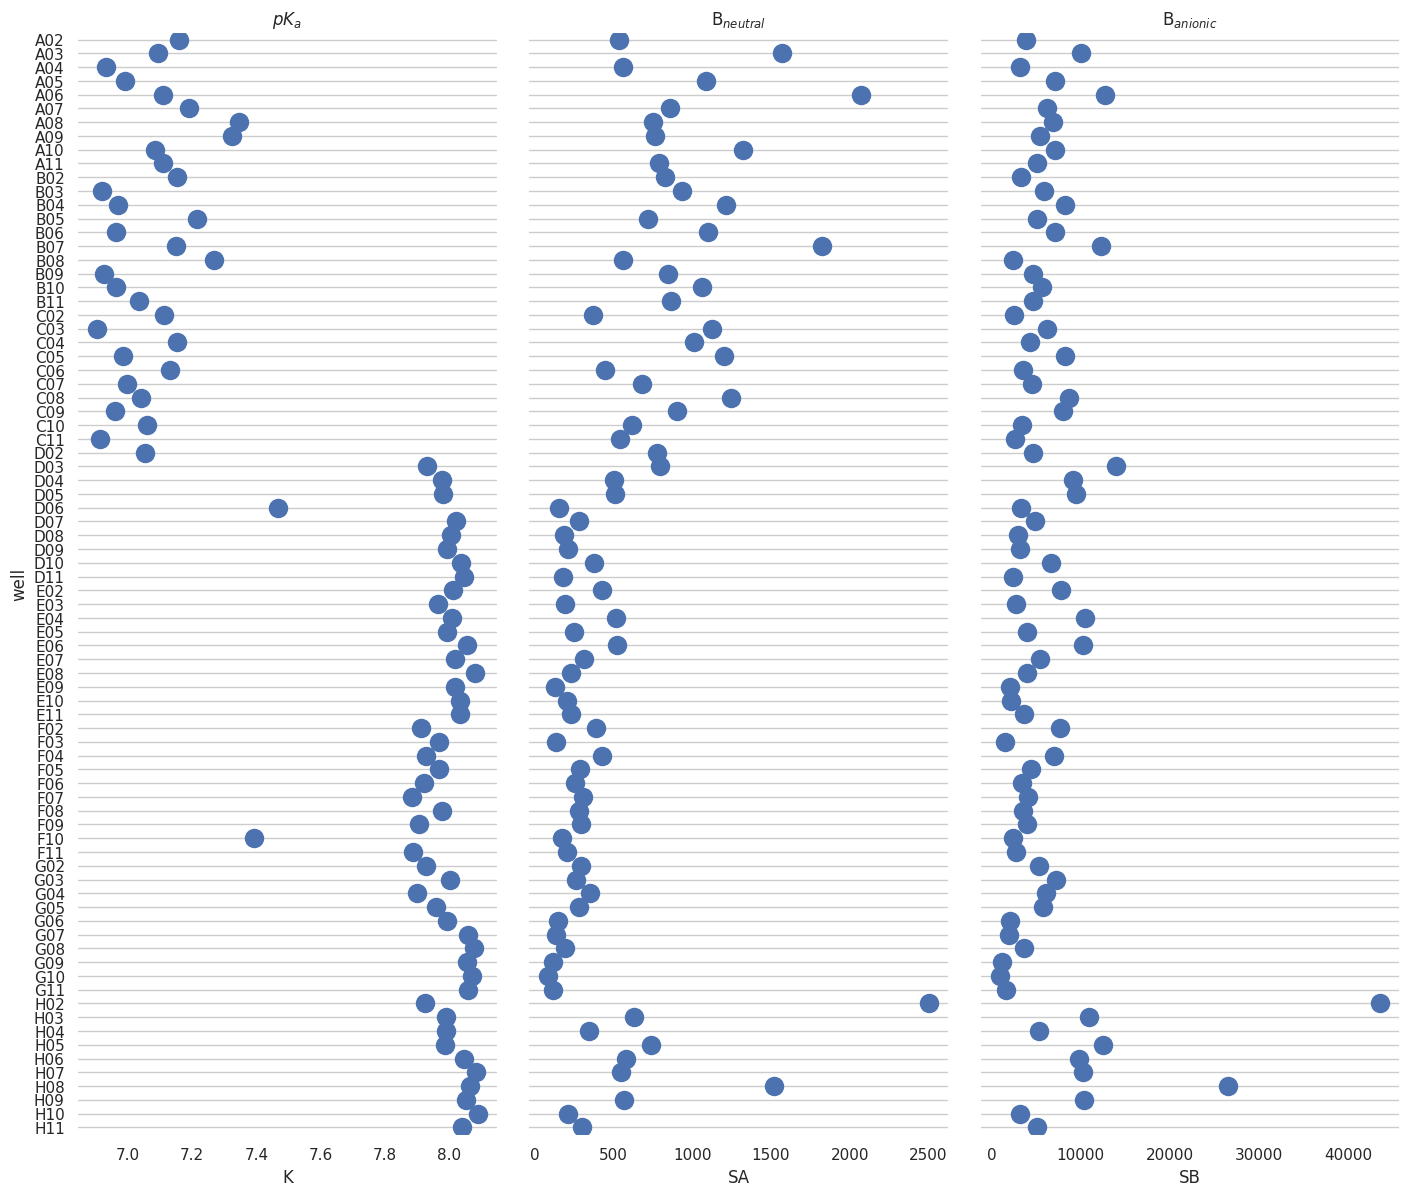

In [35]:
# g = sns.FacetGrid(data=res2, row='well',  margin_titles=True)
# g.map(plt.errorbar, 'K', range(1), xerr='sK', palette='Oranges_d') # x, y,
f = plt.figure(figsize=(24, 14))

# Make the PairGrid
g = sb.PairGrid(
    res_unk,
    x_vars=["K", "SA", "SB"],
    y_vars="well",
    height=12,
    aspect=0.4,
)


# Draw a dot plot using the stripplot function
g.map(sb.stripplot, size=14, orient="h", palette="Set2", edgecolor="gray")

# Use the same x axis limits on all columns and add better labels
# g.set(xlim=(0, 25), xlabel="Crashes", ylabel="")

# Use semantically meaningful titles for the columns
titles = ["$pK_a$", "B$_{neutral}$", "B$_{anionic}$"]


for ax, title in zip(g.axes.flat, titles):
    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sb.despine(left=True, bottom=True)